In [1]:
import re
import string
import warnings
import datetime

import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

warnings.filterwarnings('ignore')

# Data Cleaning

In [2]:
df_sbuzz = pd.read_csv("syndata/Box Office/Recruitment x Box Office x Q1 2019 - Twitter.csv", sep="\t")
df_title = pd.read_csv("syndata/Box Office/Recruitment x Box Office x Q1 2019 - Titles Performace.csv", sep="\t")

In [3]:
df_sbuzz = df_sbuzz.drop(axis=1, labels=['Unnamed: 0'])

df_sbuzz['title'] = df_sbuzz['title'].str.lower()
df_title['Title'] = df_title['Title'].str.lower()

df_title['Title'] = df_title['Title'].apply(lambda x: re.sub("[^\w\s]", "", x))
df_title['Title'] = df_title['Title'].apply(lambda x: re.sub("avengers infinty war", "avengers infinity war", x))

df_sbuzz['title'] = df_sbuzz['title'].apply(lambda x: re.sub("[^\w\s]", "", x))
df_sbuzz['title'] = df_sbuzz['title'].apply(lambda x: re.sub("predator", "the predator", x))

df_sbuzz['post_date'] = pd.to_datetime([datetime.datetime.strptime(x[0], '%Y-%m-%d').date() for x in list(df_sbuzz['post_date_time'].str.split('T'))])
df_sbuzz['post_time'] = [datetime.datetime.strptime(x[1].split('.')[0], '%H:%M:%S').time() for x in list(df_sbuzz['post_date_time'].str.split('T'))]

In [4]:
movie_dict = {}
c = 0

for i in df_sbuzz.index:
    if df_sbuzz.at[i, 'title'] not in movie_dict:
        c+=1
        movie_dict[df_sbuzz.at[i, 'title']] = c

for i in df_title.index:
    if df_title.at[i, 'Title'] not in movie_dict:
        c+=1
        movie_dict[df_title.at[i, 'Title']] = c
        
rev_movie_dict = {v:k for k, v in movie_dict.items()}

In [5]:
# movie_dict

In [6]:
# reformatting should be done better
for i in df_title.index:
    dates = df_title.at[i, 'Date']
    reg_date = re.sub("[.]|[ ]", "", dates)
    dt_list = []
    
    for d1 in reg_date.split('–'):   
        d1 = re.sub("Sept", "Sep", d1)
        m1 = ''
        if len(d1) > 3:
            month = m1.join(re.findall("[a-zA-Z]", d1))
            day = m1.join(re.findall("[0-9]", d1))

            s = '{} {} {}'.format(month, day, df_title.at[i, 'Year'])
            dt_list.append(datetime.datetime.strptime(s, '%b %d %Y').date())
            
        else:
            s = '{} {} {}'.format(month, d1, df_title.at[i, 'Year'])
            dt_list.append(datetime.datetime.strptime(s, '%b %d %Y').date())

    df_title.at[i, 'begin_date'] = dt_list[0]
    df_title.at[i, 'end_date'] = dt_list[1]

    new_range = []
    default_range = range(0, 7)
    wk_range = range(dt_list[0].weekday(), dt_list[1].weekday())
    
    if wk_range.start > wk_range.stop:
        k = wk_range.start
        for _ in range(len(default_range)):
            new_range.append(default_range[k % len(default_range)])
            k+=1
    else:
        new_range = list(wk_range)
    
    df_title.at[i, 'has_weekend'] = 5 in new_range or 6 in new_range
    df_title.at[i, 'nth_week_number'] = dt_list[0].isocalendar()[1]
    df_title.at[i, 'movie_id_t'] = int(movie_dict[df_title.at[i, 'Title']])
    df_title.at[i, 'gross_to_date_float'] = float(re.sub('[^\d.]', '', df_title.at[i, 'Gross-to-Date']))
    try:
        df_title.at[i, 'weekend_gross_float'] = float(re.sub('[^\d.]', '', df_title.at[i, 'Weekend Gross']))
    except:
        df_title.at[i, 'weekend_gross_float'] = 0
        

In [7]:
for i in df_sbuzz.index:
    df_sbuzz.at[i, 'movie_id_s'] = int(movie_dict[df_sbuzz.at[i, 'title']])
    df_sbuzz.at[i, 'nth_week_number'] = df_sbuzz.at[i, 'post_date'].isocalendar()[1]
    df_sbuzz.at[i, 'is_influencer'] = df_sbuzz.at[i, 'user_followers_count'] > 10000

In [8]:
analyzer = SentimentIntensityAnalyzer()
df_sbuzz['tweet_sentiment'] = pd.Series(map(lambda x: x['compound'], df_sbuzz['post_content'].apply(analyzer.polarity_scores)))

In [9]:
titles = list(df_title['movie_id_t'].unique())
titles_buzz =  list(df_sbuzz['movie_id_s'].unique())
len(set(titles).intersection(titles_buzz))

19

In [10]:
df_title.sample(3) 

,Title,Date,Year,Rank,Weekend Gross,Gross-to-Date,Week # of release,begin_date,end_date,has_weekend,nth_week_number,movie_id_t,gross_to_date_float,weekend_gross_float
142,coco,Jan. 11–14,2018,8,"$817,454","$6,358,595",3,2018-01-11,2018-01-14,True,2.0,10.0,6358595.0,817454.0
125,star wars the last jedi,Dec. 14–17,2017,1,"$16,036,588","$16,036,588",1,2017-12-14,2017-12-17,True,50.0,8.0,16036588.0,16036588.0
47,the greatest showman,Mar. 15–18,2018,8,"$276,506","$25,371,529",12,2018-03-15,2018-03-18,True,11.0,3.0,25371529.0,276506.0


In [11]:
df_sbuzz.sample(3)

,ID,title,post_link,post_date_time,post_content,user_name,user_bio,user_followers_count,user_followee_count,user_post_count,country,state,language,post_date,post_time,movie_id_s,nth_week_number,is_influencer,tweet_sentiment
38984,6,star wars the last jedi,http://twitter.com/GeekOutVlogs/status/9490844...,2018-01-05T01:05:34.000+0000,I added a video to a @YouTube playlist https:/...,GeekOutVlogs,"Not your average youtube Vloggers, Join the ch...",783,1363,1289,AUS,Tasmania,en,2018-01-05,01:05:34,8.0,1.0,False,-0.7111
31305,5,wonder woman,http://twitter.com/thereafter/status/874546483...,2017-06-13T08:38:24.000+0000,RT @WonderWomanFilm Discover how the world of ...,thereafter,i like cats. insta: @buries,175,200,15253,AUS,New South Wales,en,2017-06-13,08:38:24,7.0,24.0,False,0.0000
68255,17,bright,http://twitter.com/rachitmathur5/status/948118...,2018-01-02T09:07:33.000+0000,@bartlett_kate Its bright and sunny outside 😉😉,rachitmathur5,NaN,910,679,66867,AUS,New South Wales,en,2018-01-02,09:07:33,17.0,1.0,False,0.6908


-----------

# Analysis through feature engineering and visualization

In [12]:
plt.rcParams['figure.figsize'] = [16, 10]
sns.set(color_codes=True)

### Cumulative movie sales in the box office:

In [13]:
agg_cost = df_title.groupby(['Title']).sum()[['gross_to_date_float']].sort_values(
    by='gross_to_date_float', ascending=False)

In [14]:
weekend_to_total = df_title[['Title', 'weekend_gross_float', 'gross_to_date_float']]
weekend_to_total = weekend_to_total.fillna(0)

In [15]:
# weekend sales and gross total are negatively correlated
stats.spearmanr(weekend_to_total['weekend_gross_float'], weekend_to_total['gross_to_date_float'])

SpearmanrResult(correlation=-0.12802988502257107, pvalue=0.04187736925949874)

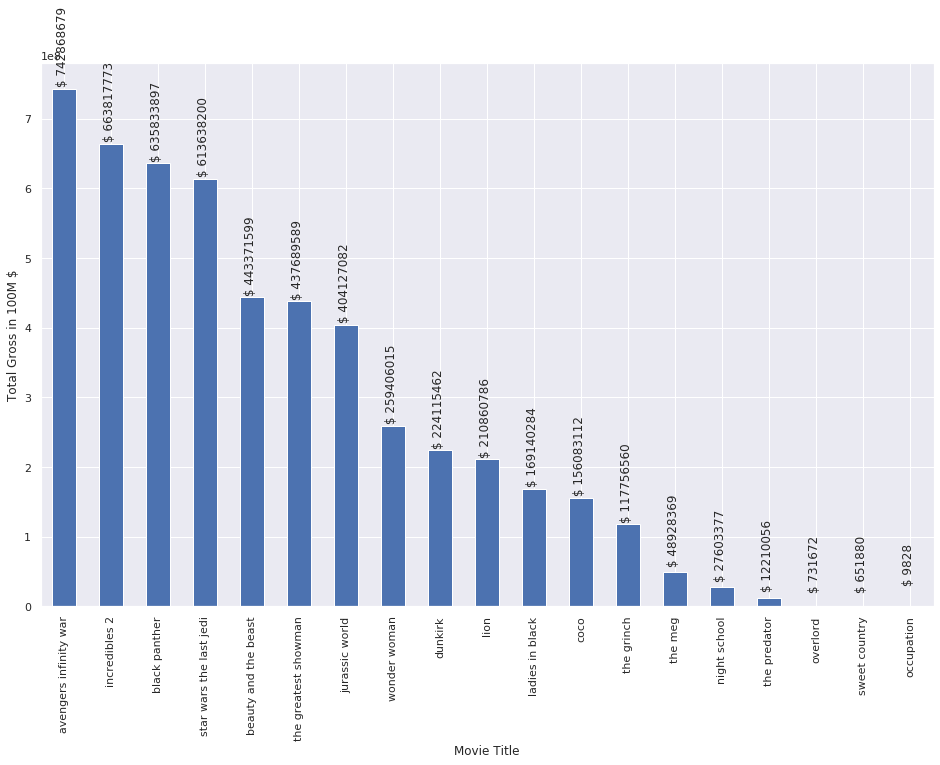

In [16]:
ax = agg_cost.plot(kind='bar', legend=False)
ax.set_xlabel("Movie Title")
ax.set_ylabel("Total Gross in 100M $")

for p in ax.patches:
    ax.annotate(' $ '+str(int(p.get_height())), (p.get_x(), p.get_height()), 
                ha = 'center', va = 'center', xytext = (10, 40), textcoords = 'offset points', rotation=90)

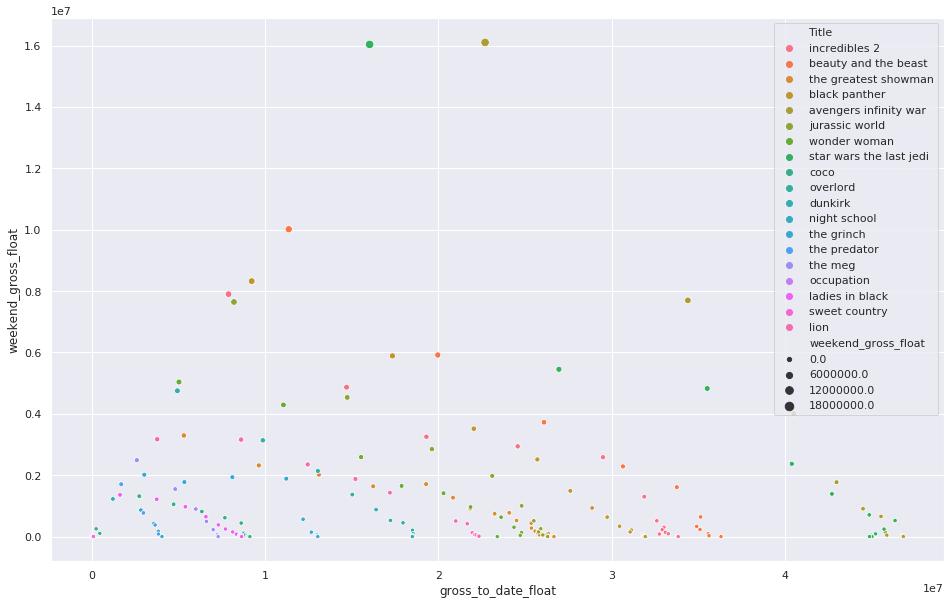

In [17]:
sns.scatterplot(data=weekend_to_total, hue = "Title", 
                y="weekend_gross_float", x="gross_to_date_float", 
                size="weekend_gross_float");

# weekend sales are initially high when the movie releases and 
# thereafter it starts declining while though total sales keeps increasing

### Sales distributed across weeks

In [18]:
by_week = (df_title
            .groupby(['Title', 'Week # of release'])
            .size()
            .unstack())

by_nth_week = (df_title
              .groupby(['Title', 'nth_week_number'])
              .size()
              .unstack())

In [19]:
for idx in by_week.index:
    for col in by_week.columns:
        
        try:
            by_week.at[idx, col] = float(df_title[(df_title['Title']==idx) & (df_title['Week # of release']==col)]['gross_to_date_float'])
        except:
            by_week.at[idx, col] = np.nan
            
for idx in by_nth_week.index:
    for col in by_nth_week.columns:
        
        try:
            by_nth_week.at[idx, col] = float(df_title[(df_title['Title']==idx) & (df_title['nth_week_number']==col)]['gross_to_date_float'])
        except:
            by_nth_week.at[idx, col] = np.nan

In [20]:
# by_week.sample(3)
# by_nth_week.sample(3)

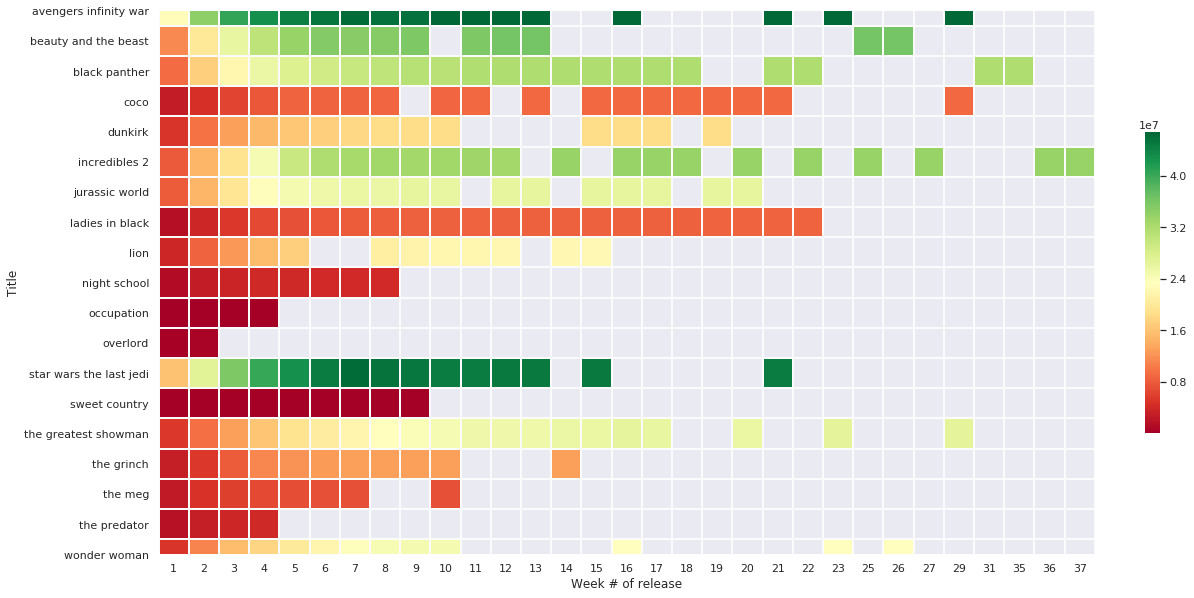

In [21]:
plt.figure(figsize=(18,10))
week_releases = sns.heatmap(
    by_week, 
    square=True, 
    cbar_kws={'fraction' : 0.015}, 
    cmap='RdYlGn',
    linewidth=1,
    linecolor="#fbfbfb"
)

# given box office sales for movies that have only performed good, i.e. sales keep increasing after every week

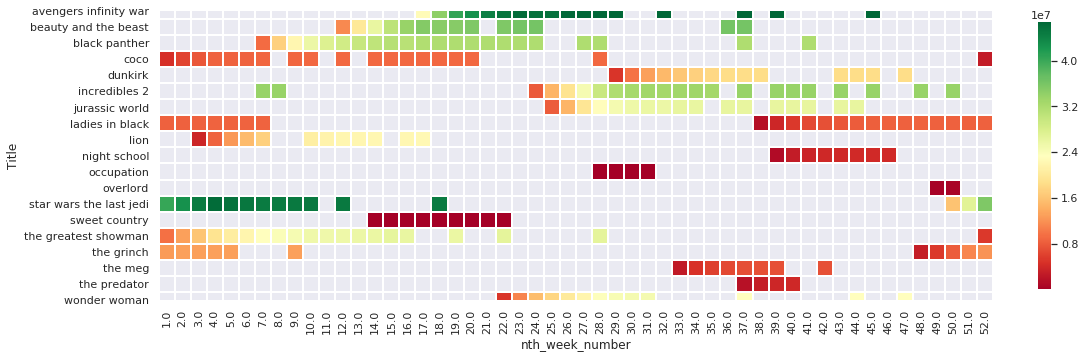

In [22]:
# perform same heatmap analysis for nth week of the year sales
nth_week_releases = sns.heatmap(
    by_nth_week, 
    square=True, 
    cbar_kws={'fraction' : 0.015}, 
    cmap='RdYlGn',
    linewidth=1 
)

### Do tweets effect sales?

In [23]:
tweets_per_movie_date = df_sbuzz.groupby(['movie_id_s', 'title', 'post_date']).size().unstack(1)

In [24]:
box_vs_tweets = df_title[['movie_id_t', 'Title', 'begin_date', 'end_date', 'gross_to_date_float', 'weekend_gross_float']]

In [25]:
box_vs_tweets["tweets_received"] = 0

In [26]:
for m_id, time in tweets_per_movie_date.index:
    curr_df = box_vs_tweets[box_vs_tweets['movie_id_t']==m_id]
    for idx in curr_df.index:
        
        if curr_df.at[idx, 'begin_date'] < time < curr_df.at[idx, 'end_date']:
            box_vs_tweets.at[idx, 'tweets_received'] = tweets_per_movie_date.loc[(m_id, time), rev_movie_dict[m_id]]

        if curr_df.at[idx, 'begin_date'] > time or curr_df.at[idx, 'begin_date'] < time:
            new_idx = len(box_vs_tweets)+1
            box_vs_tweets.at[new_idx, 'begin_date'] = time.date()
            box_vs_tweets.at[new_idx, 'end_date'] = time.date()
            box_vs_tweets.at[new_idx, 'Title'] = rev_movie_dict[m_id]
            box_vs_tweets.at[new_idx, 'movie_id_t'] = m_id
            box_vs_tweets.at[new_idx, 'tweets_received'] = tweets_per_movie_date.loc[(m_id, time), rev_movie_dict[m_id]]
        
    box_vs_tweets.drop_duplicates(inplace=True)

In [27]:
# tweets_per_movie_date

In [28]:
box_vs_tweets = (box_vs_tweets
                 .sort_values(by=['movie_id_t', 'begin_date'])
                 .reset_index()
                 .drop(axis=1, labels=['index'])
                 .fillna(0))

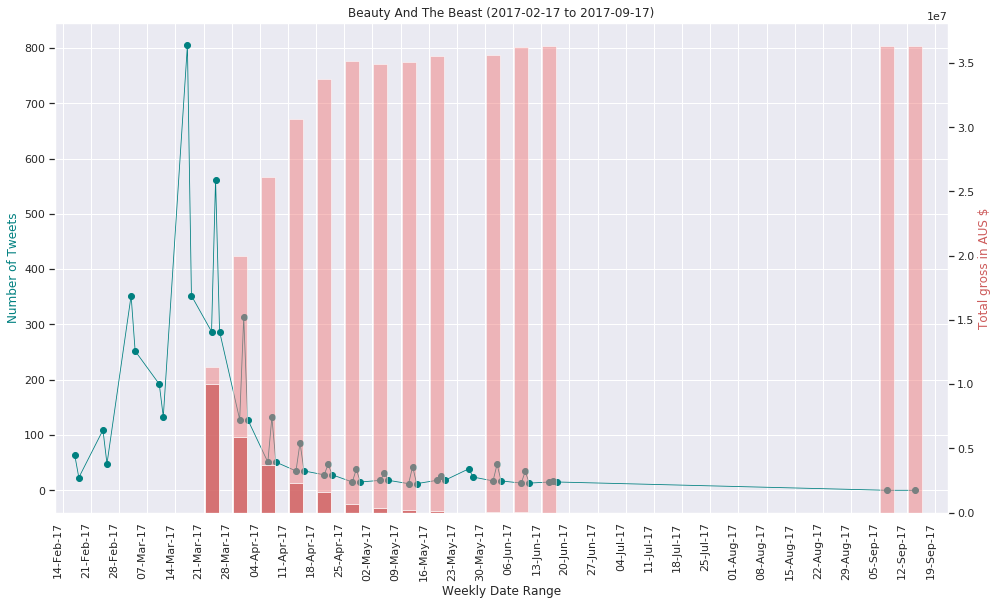

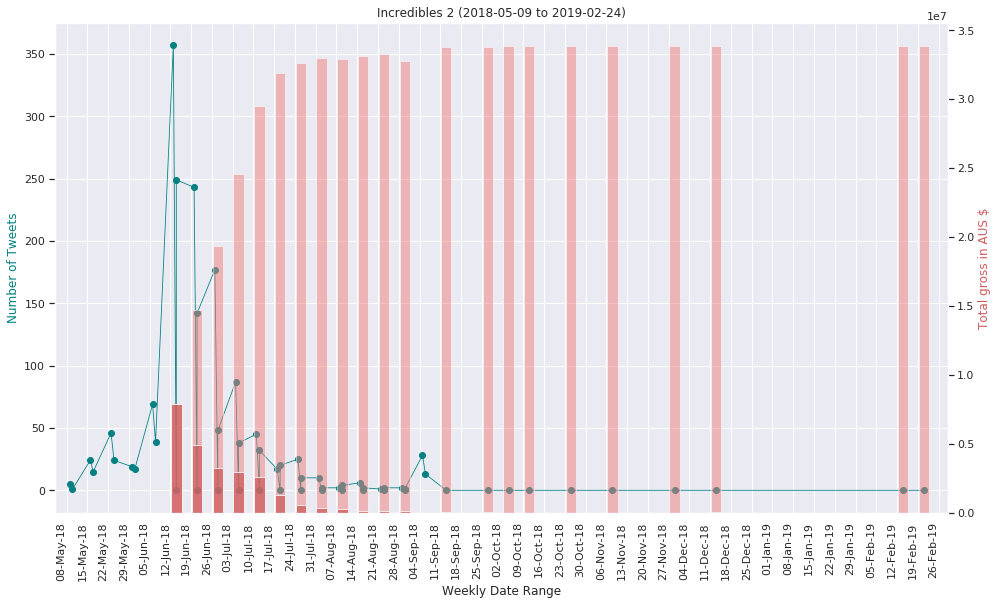

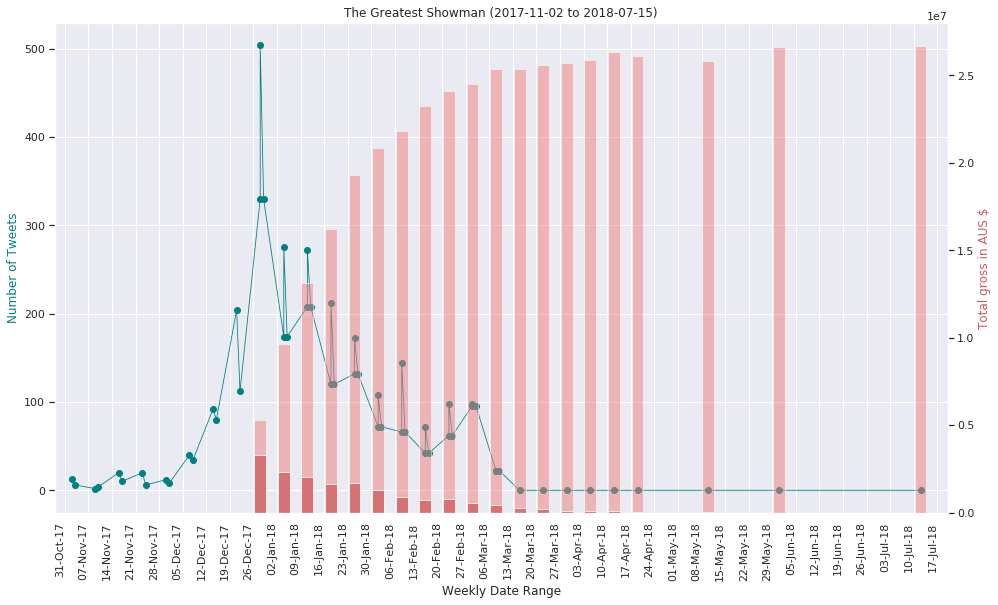

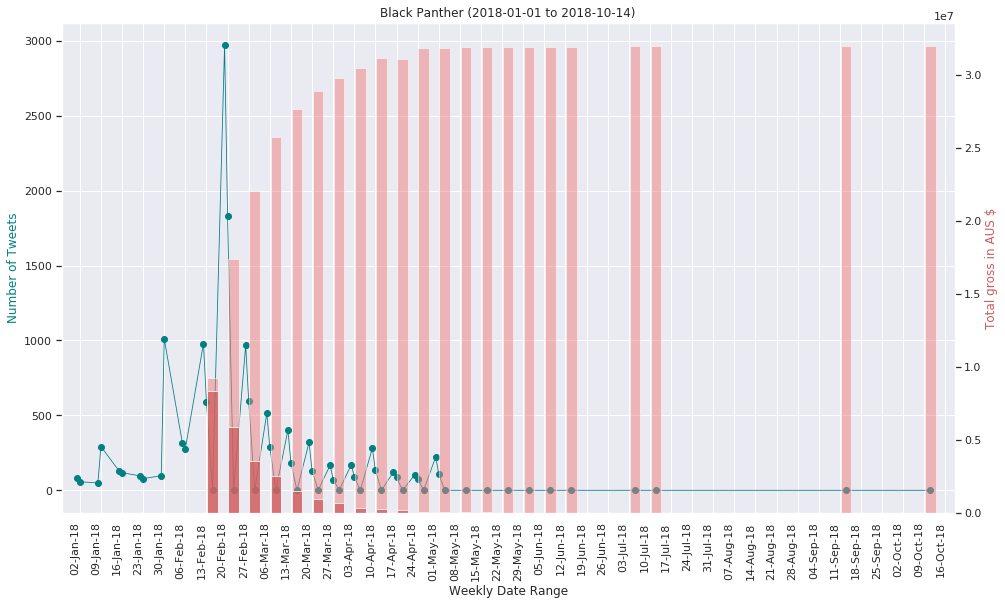

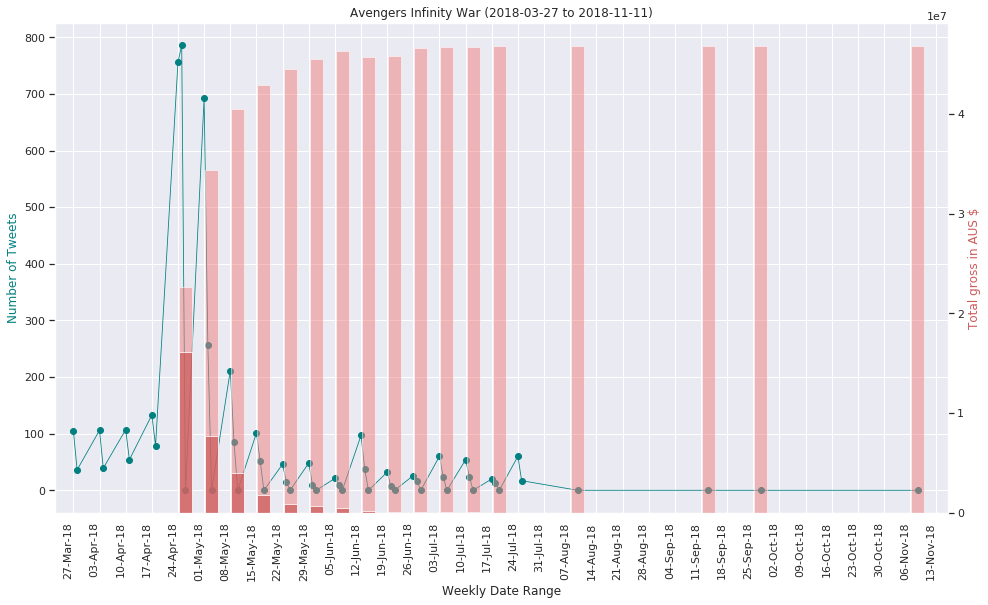

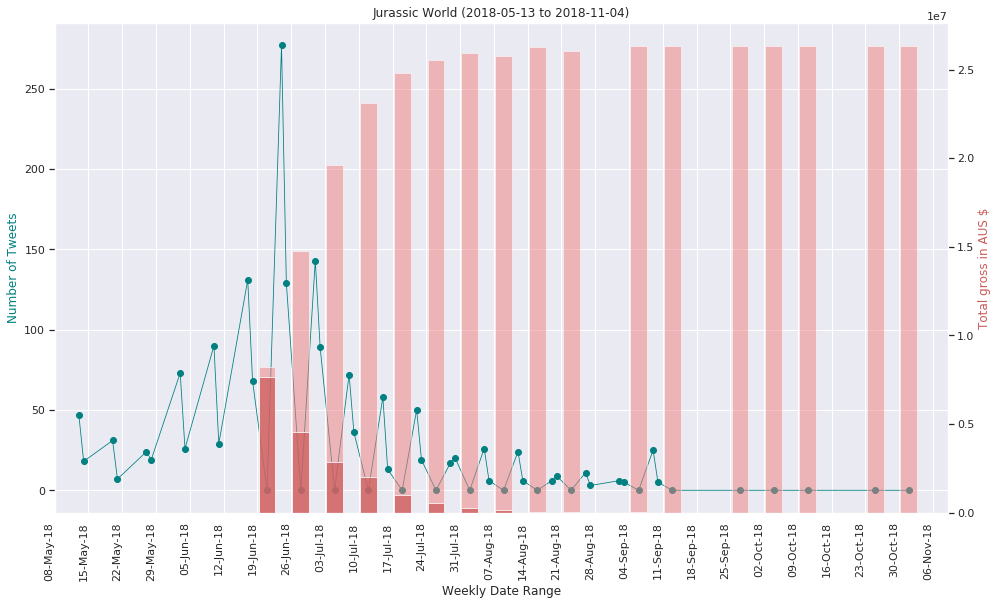

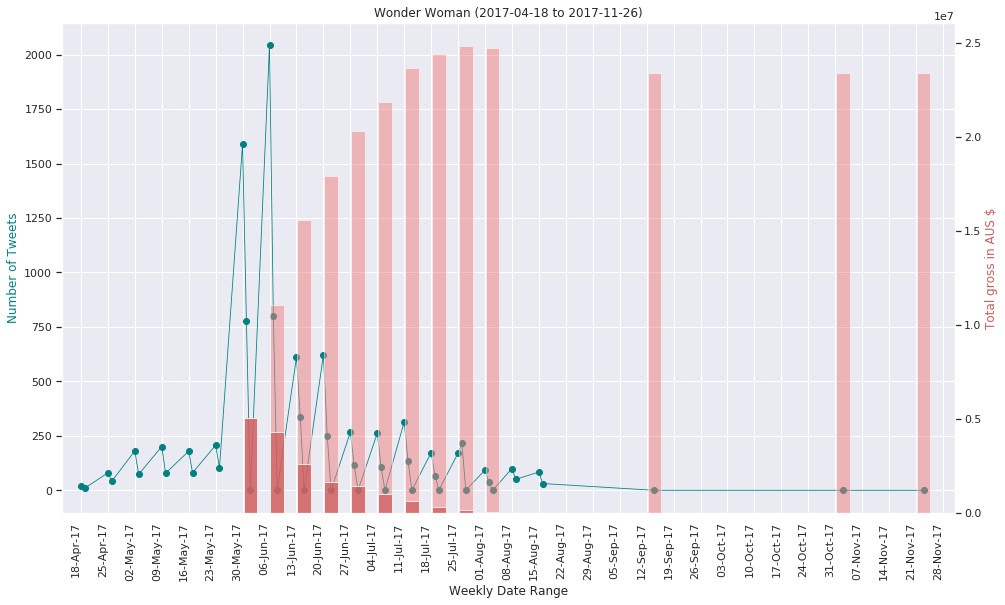

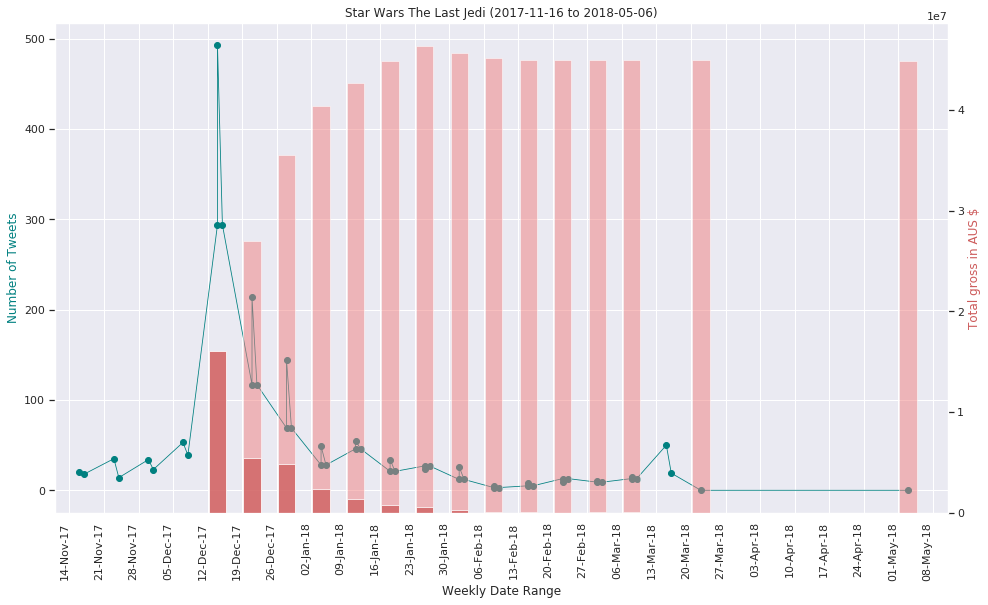

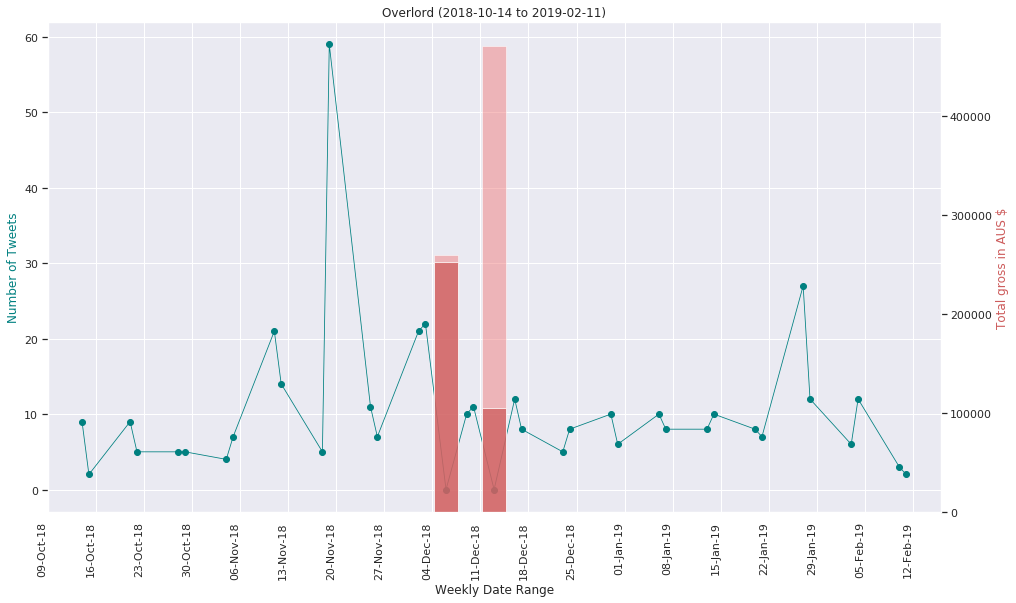

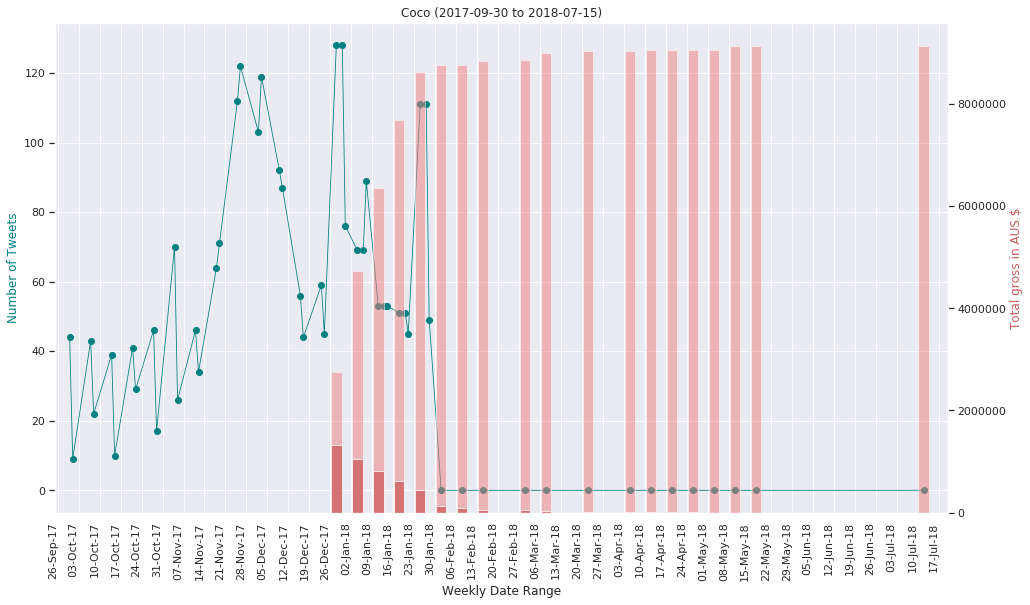

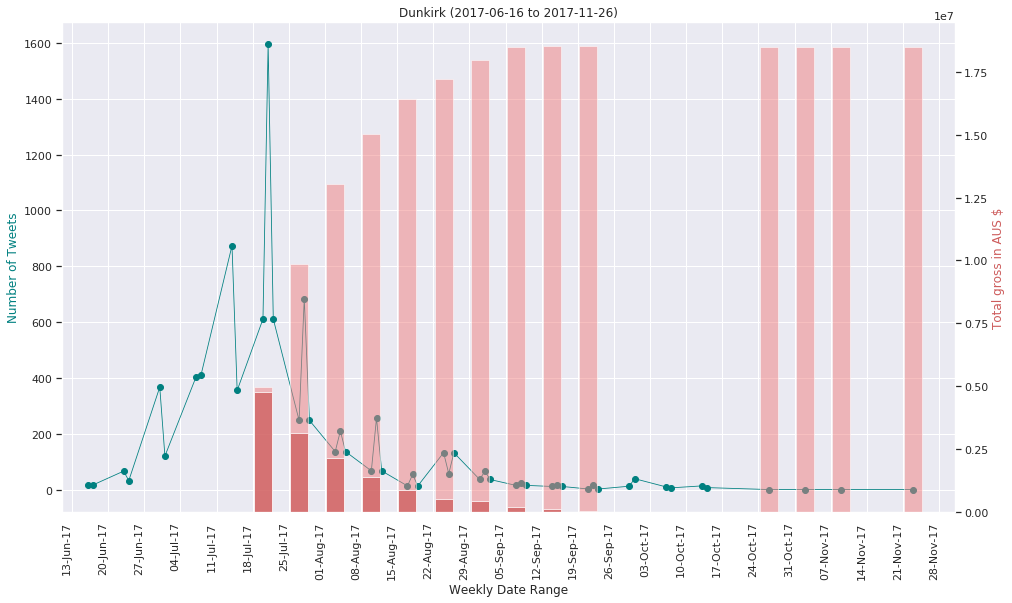

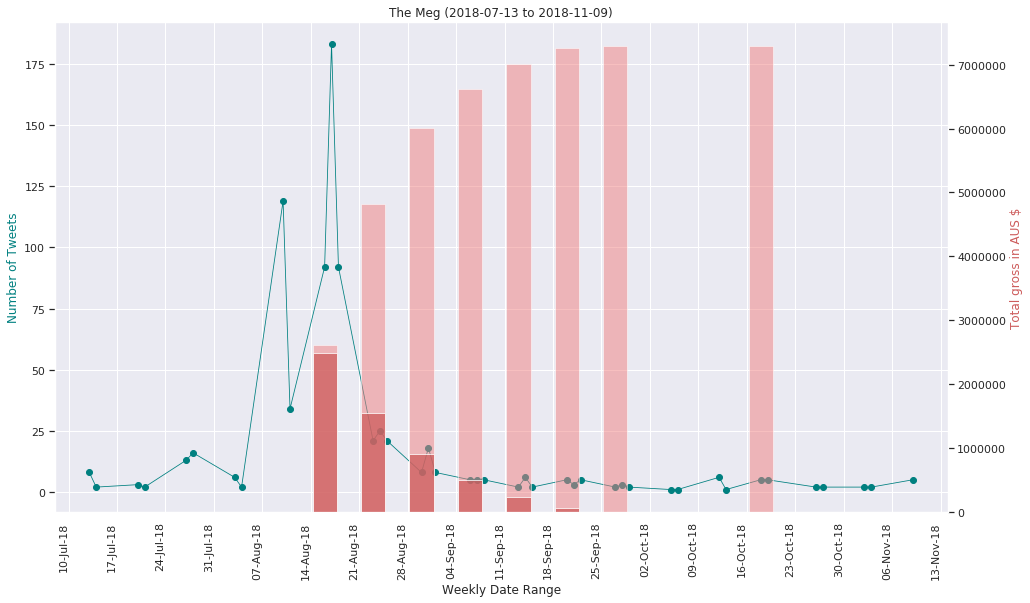

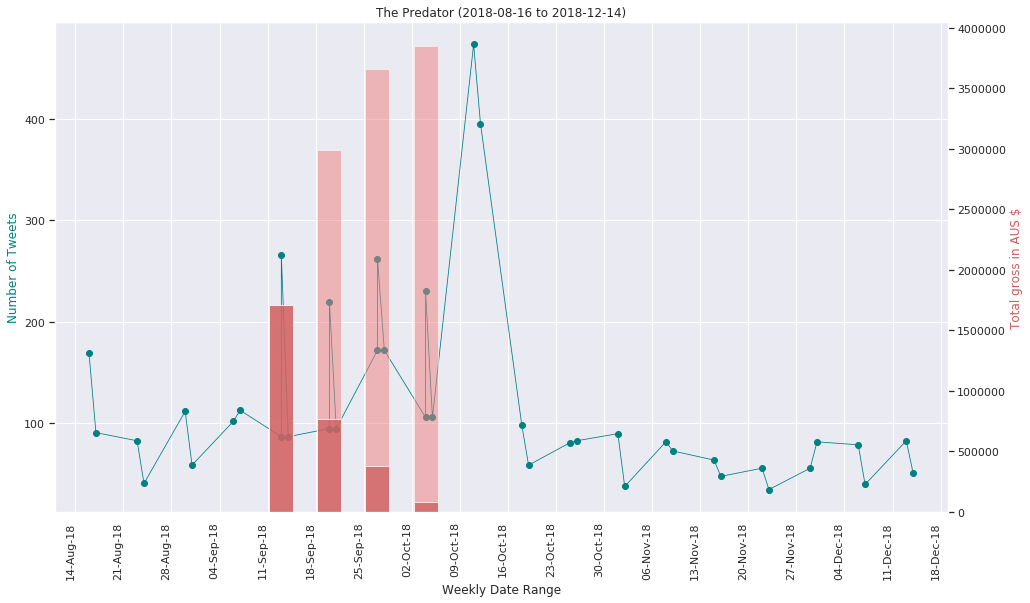

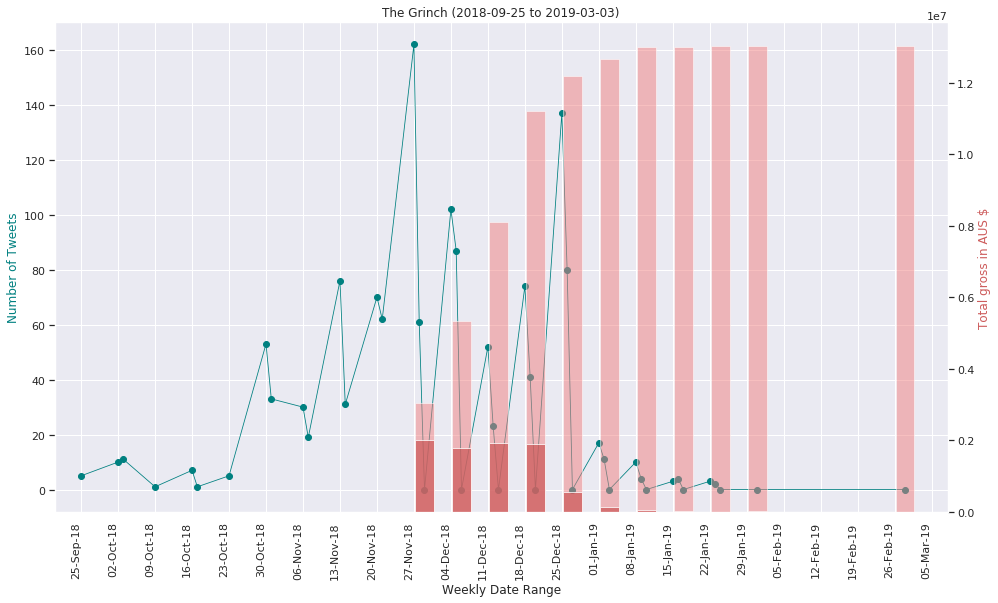

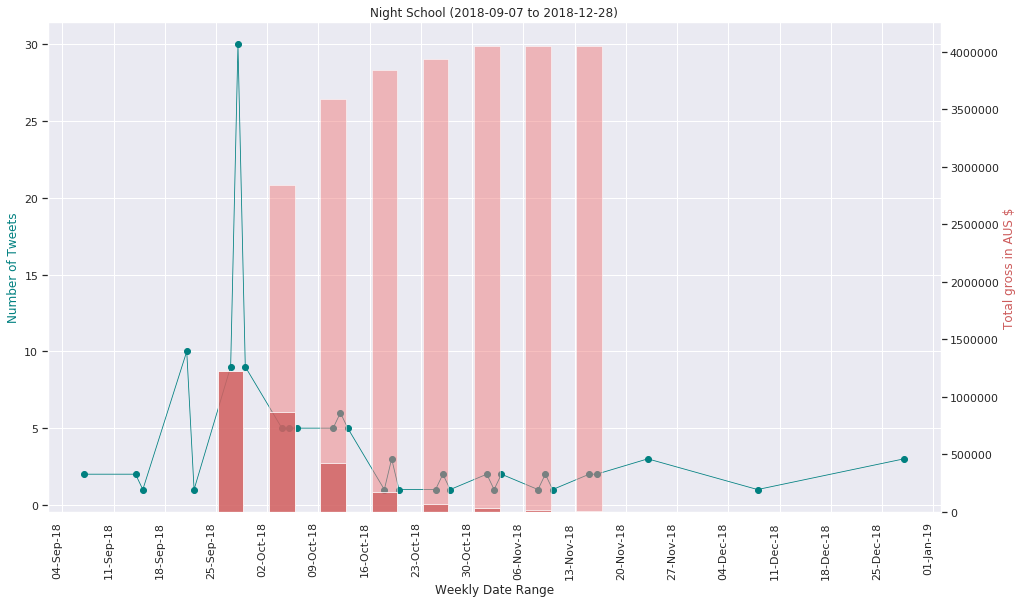

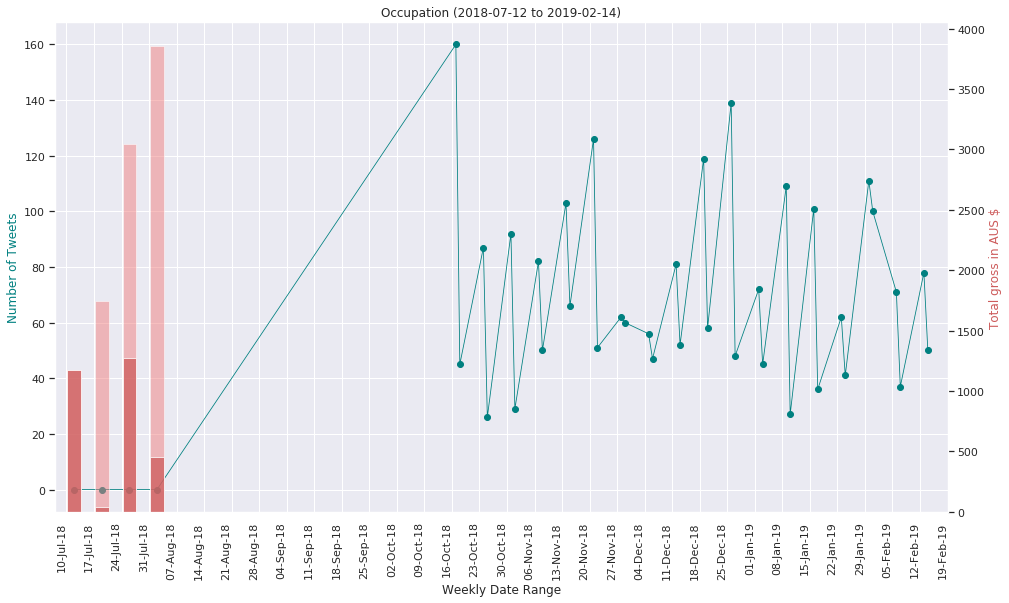

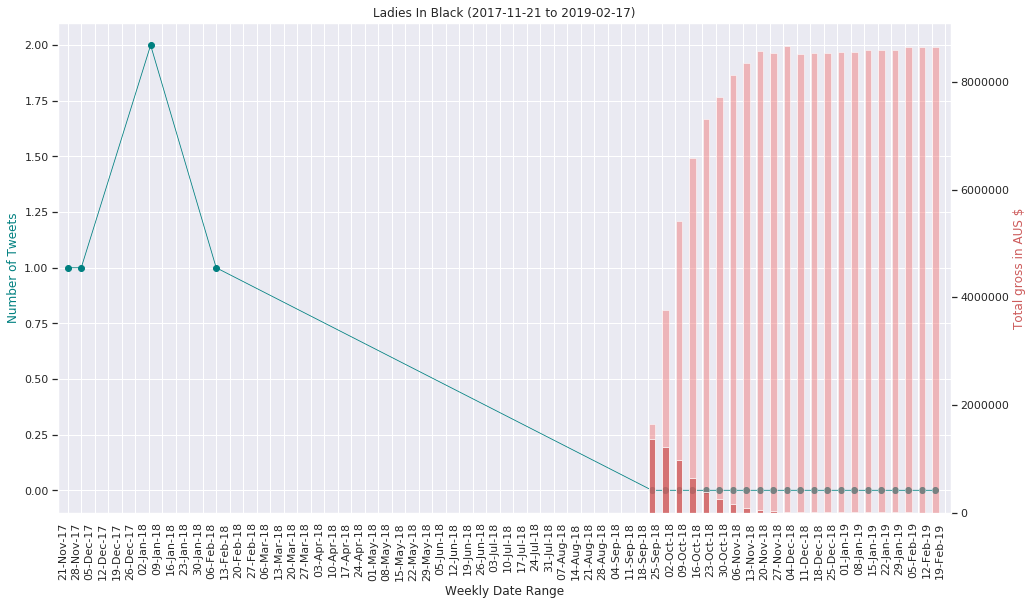

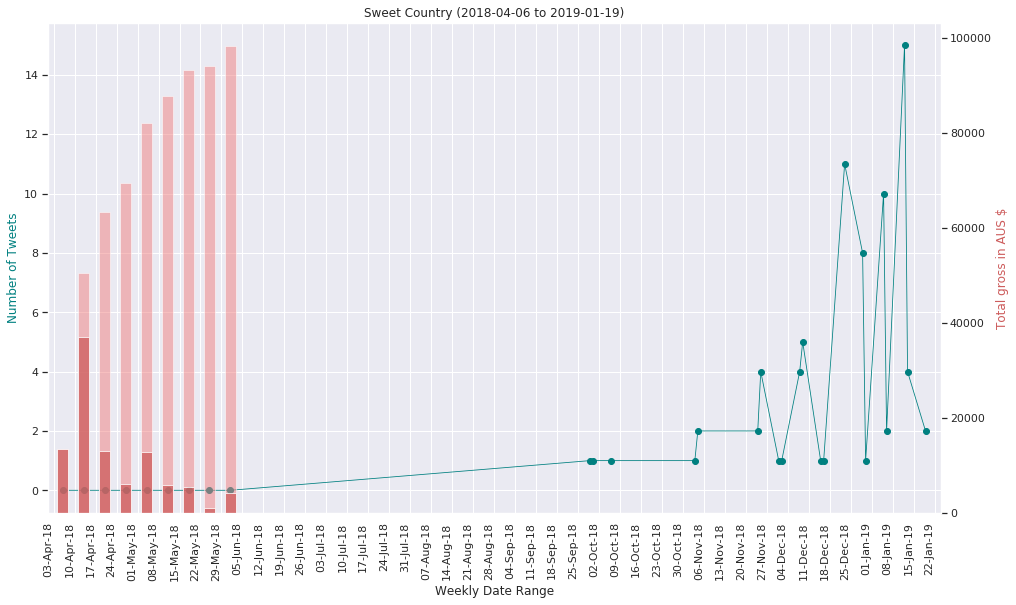

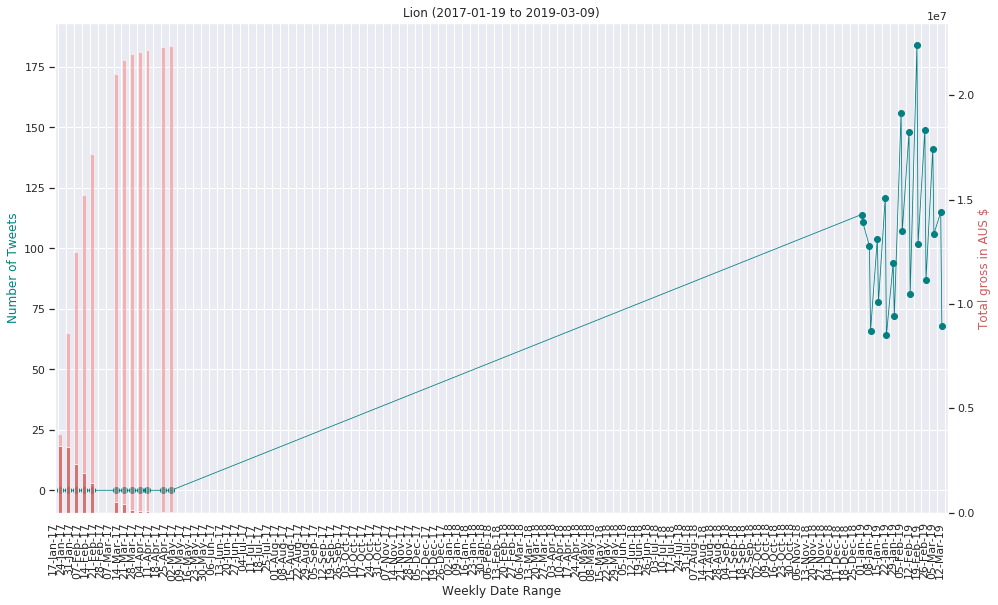

In [29]:
for group in box_vs_tweets.groupby(['movie_id_t']):
    
    # plot for each movie individually
    # change plotting visual style.
    
    date_form = DateFormatter("%d-%b-%y")
    
    mini = group[1]
    start_date_lim = mini['begin_date'].iloc[0] - datetime.timedelta(days=5)
    end_date_lim = mini['end_date'].iloc[len(mini)-1] + datetime.timedelta(days=5)

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    ax1.set_title("{} ({} to {})".format(string.capwords(mini['Title'].iloc[0]), mini['begin_date'].iloc[0], mini['end_date'].iloc[len(mini)-1]))
    ax1.plot(mini['begin_date'], mini['tweets_received'], color="teal", marker="o", linewidth=0.8)
    ax1.set_ylabel("Number of Tweets")
    ax1.yaxis.label.set_color('teal')

    ax2 = ax1.twinx()
    ax2.bar(x=mini['begin_date'], height=mini['gross_to_date_float'], width=3.5, alpha=0.5, color="lightcoral")
    ax2.bar(x=mini['begin_date'], height=mini['weekend_gross_float'], width=3.5, alpha=0.75, color="indianred")
    ax2.set_ylabel("Total gross in AUS $")
    ax2.yaxis.label.set_color('indianred')
    ax2.grid(False)

    ax1.set_xlabel("Weekly Date Range")

    # Define the date format
    fig.autofmt_xdate(rotation=90)

    ax1.set_xlim([start_date_lim, end_date_lim])

    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

### Sentiment of tweets

In [30]:
sub = df_sbuzz[['movie_id_s', 'title', 'post_date', 'tweet_sentiment']]

In [31]:
# print(stats.mode(sub['tweet_sentiment']).mode)
# print(np.mean(sub['tweet_sentiment']))
# print(np.median(sub['tweet_sentiment']))

In [53]:
# mini = sub.groupby(['movie_id_s', 'title', 'post_date'])['tweet_sentiment'].agg(pd.Series.mode).unstack(1)
mini = sub.groupby(['movie_id_s', 'title', 'post_date'])['tweet_sentiment'].mean().unstack(1)

In [45]:
# mini

In [54]:
box_vs_sentiment = df_title[['movie_id_t', 'Title', 'begin_date', 'end_date', 'gross_to_date_float', 'weekend_gross_float']]

In [55]:
box_vs_sentiment['tweet_sentiment'] = 0

In [56]:
for m_id, time in mini.index:
    curr_df = box_vs_sentiment[box_vs_sentiment['movie_id_t']==m_id]
    for idx in curr_df.index:
        
        if curr_df.at[idx, 'begin_date'] < time < curr_df.at[idx, 'end_date']:
            box_vs_sentiment.at[idx, 'tweet_sentiment'] = np.mean(mini.loc[(m_id, time), rev_movie_dict[m_id]])

        if curr_df.at[idx, 'begin_date'] > time or curr_df.at[idx, 'begin_date'] < time:
            new_idx = len(box_vs_sentiment)+1
            box_vs_sentiment.at[new_idx, 'begin_date'] = time.date()
            box_vs_sentiment.at[new_idx, 'end_date'] = time.date()
            box_vs_sentiment.at[new_idx, 'Title'] = rev_movie_dict[m_id]
            box_vs_sentiment.at[new_idx, 'movie_id_t'] = m_id
            box_vs_sentiment.at[new_idx, 'tweet_sentiment'] = np.mean(mini.loc[(m_id, time), rev_movie_dict[m_id]])
        
    box_vs_sentiment.drop_duplicates(inplace=True)

In [57]:
box_vs_sentiment = (box_vs_sentiment
                 .sort_values(by=['movie_id_t', 'begin_date'])
                 .reset_index()
                 .drop(axis=1, labels=['index'])
                 .fillna(0))

In [58]:
# box_vs_sentiment

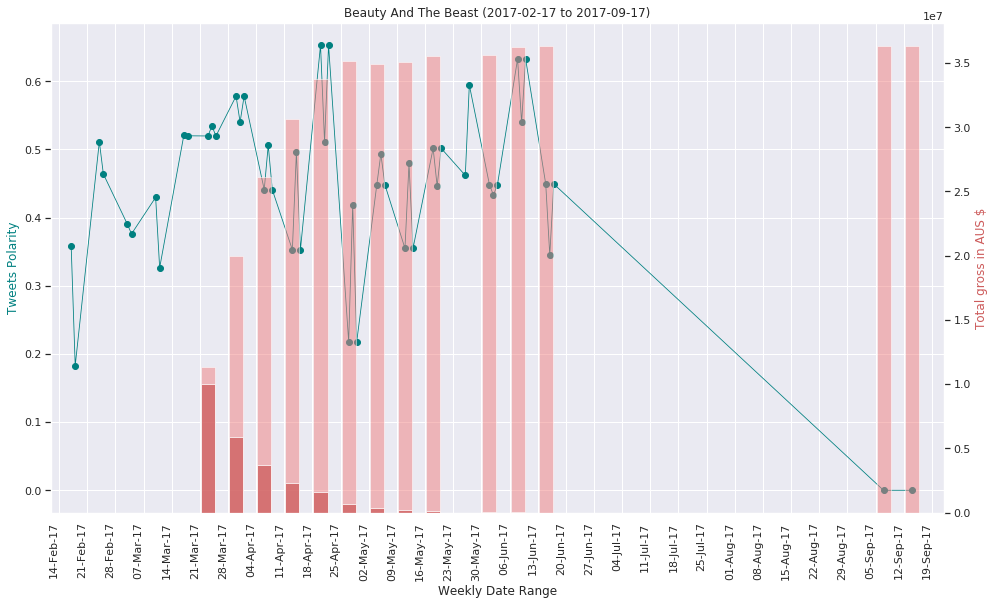

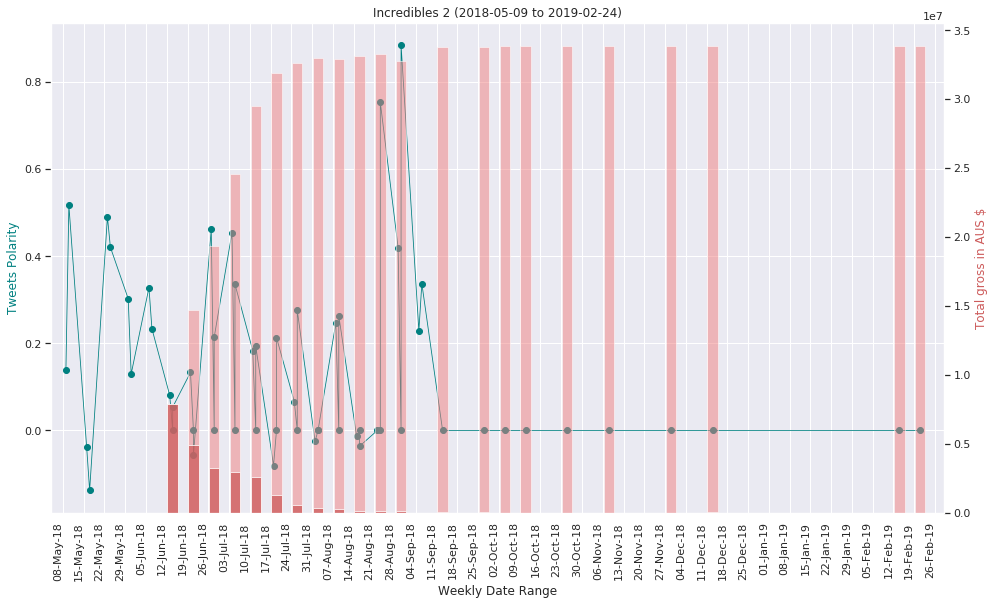

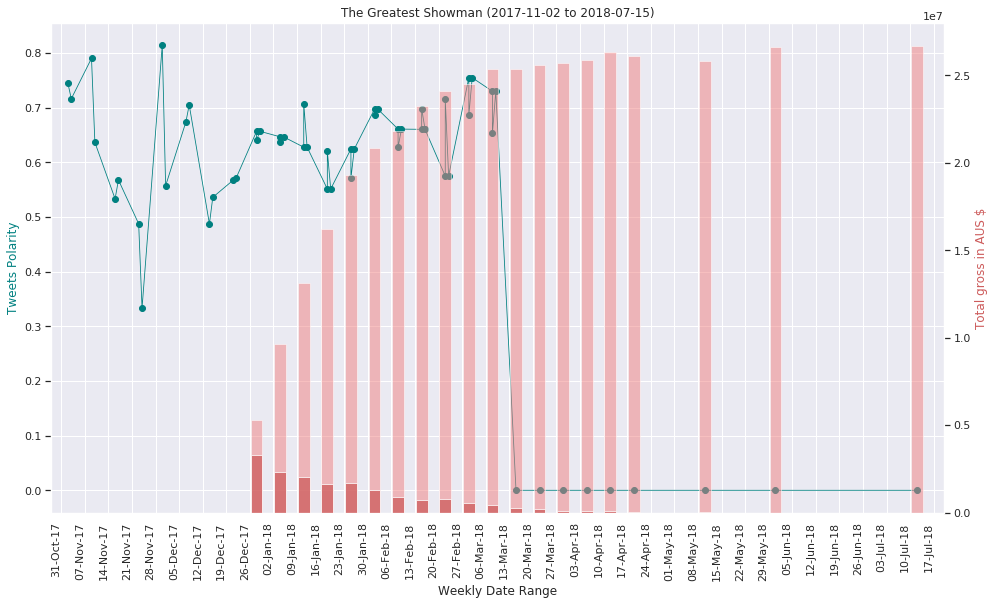

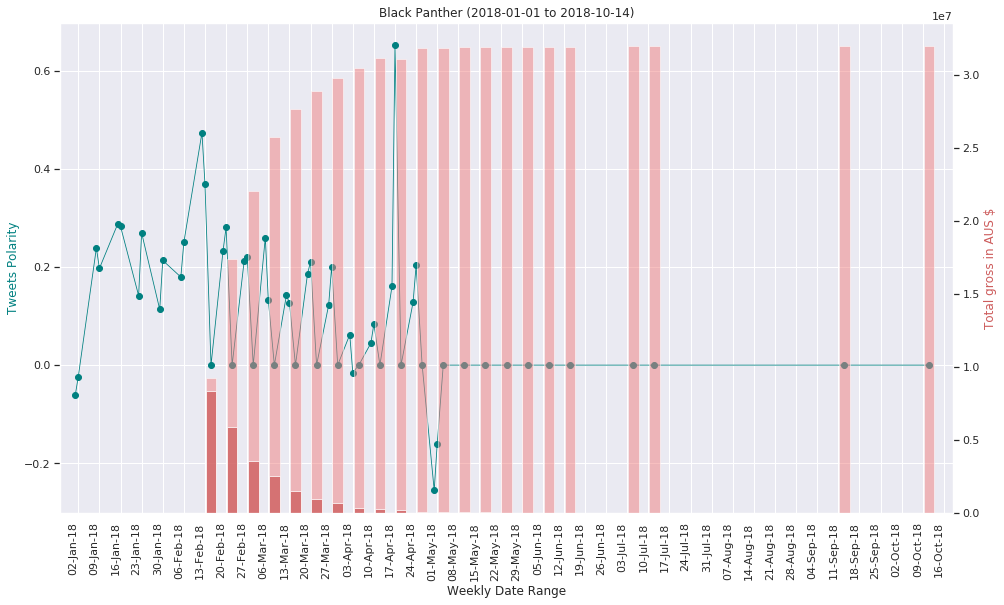

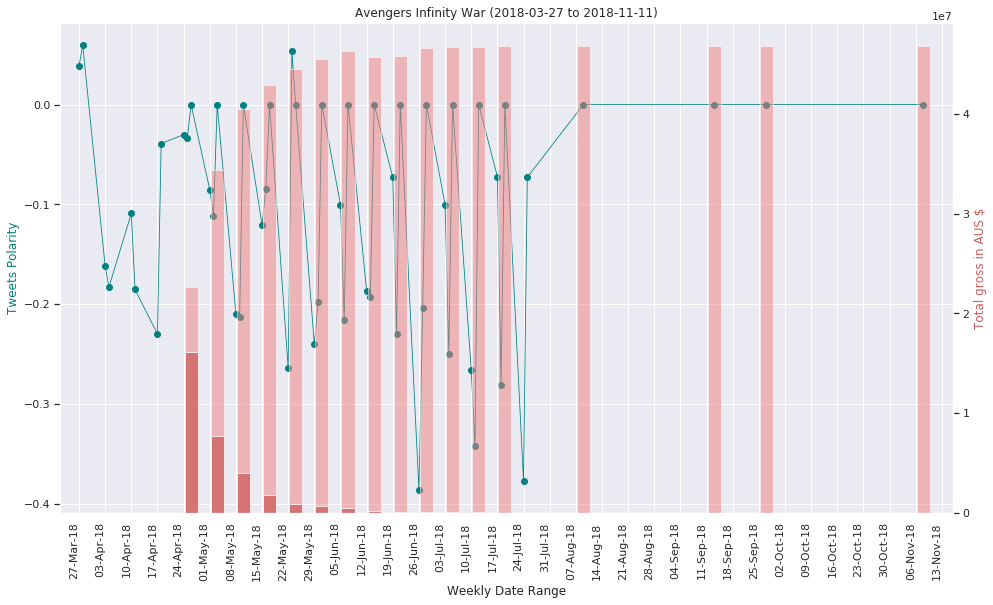

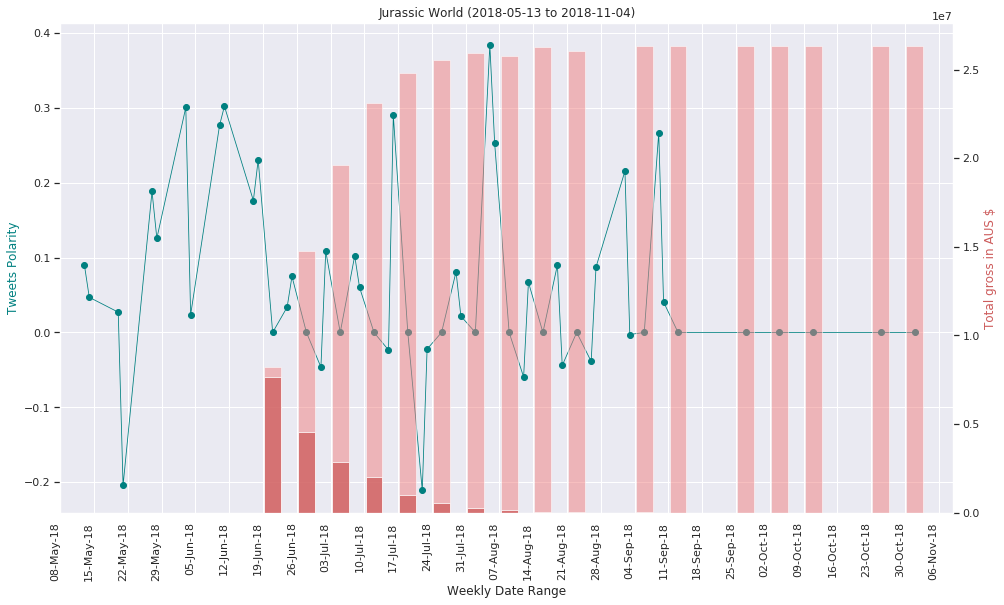

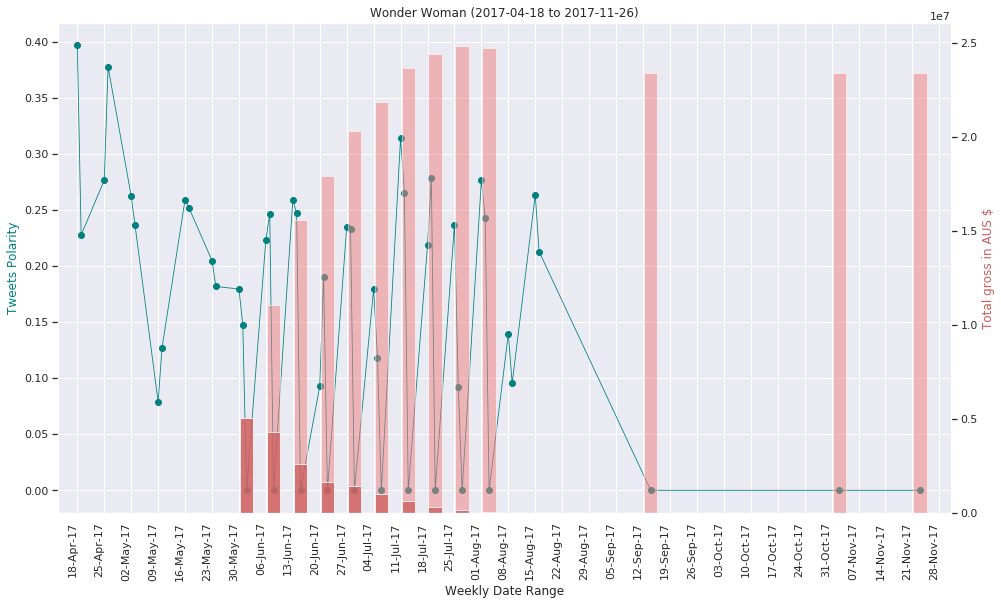

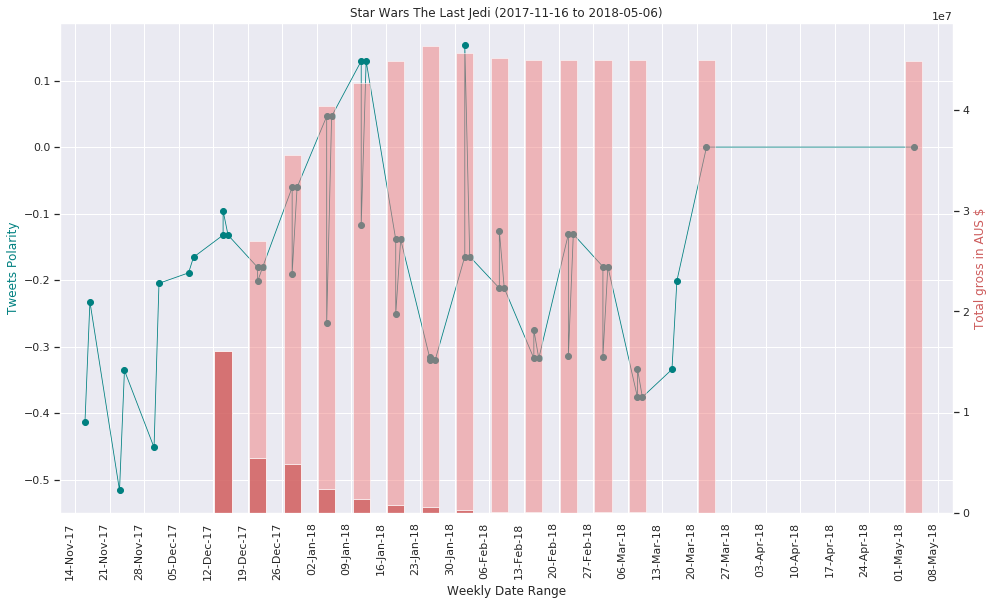

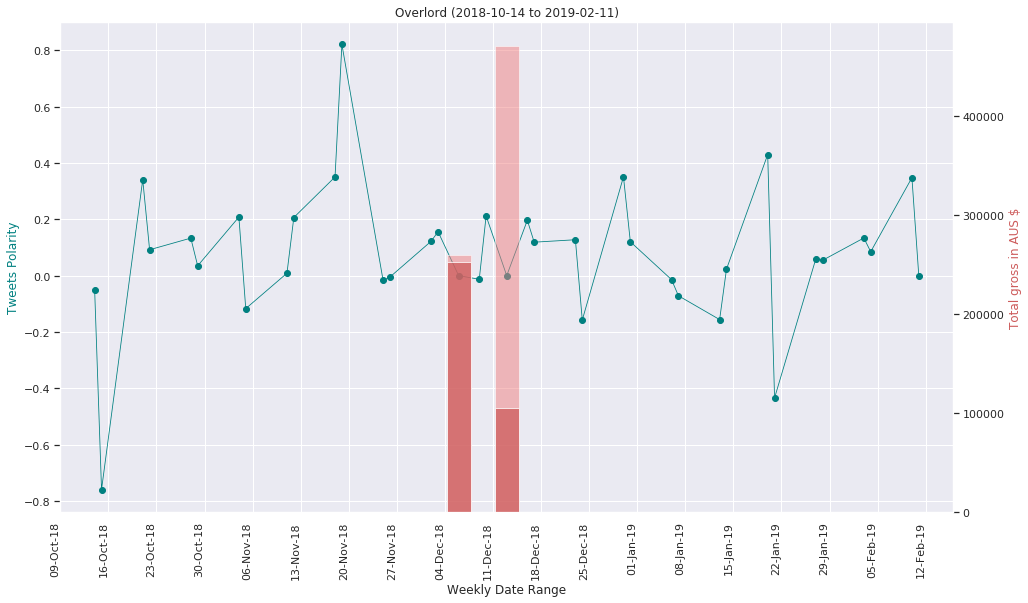

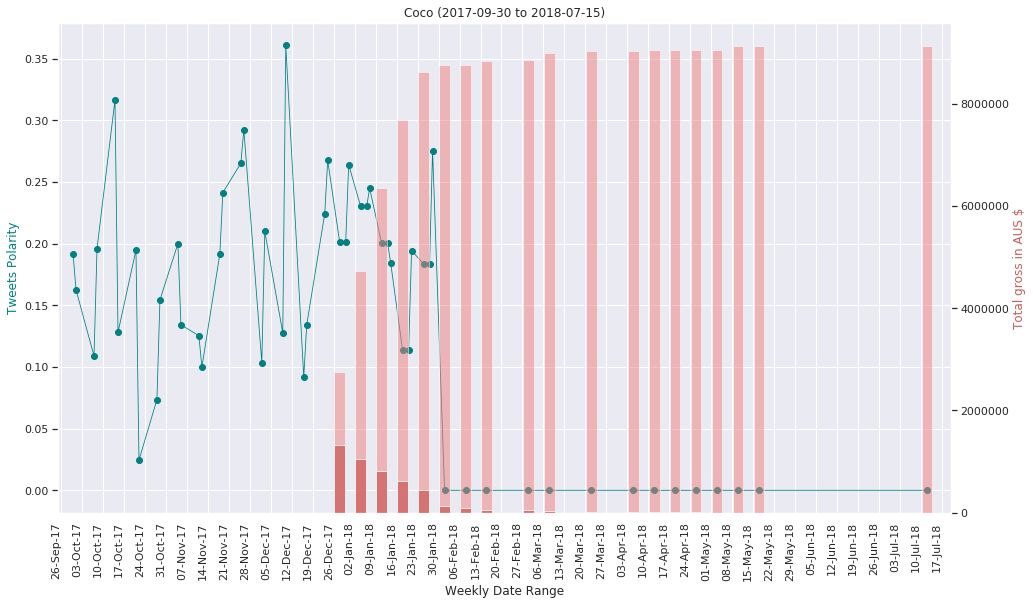

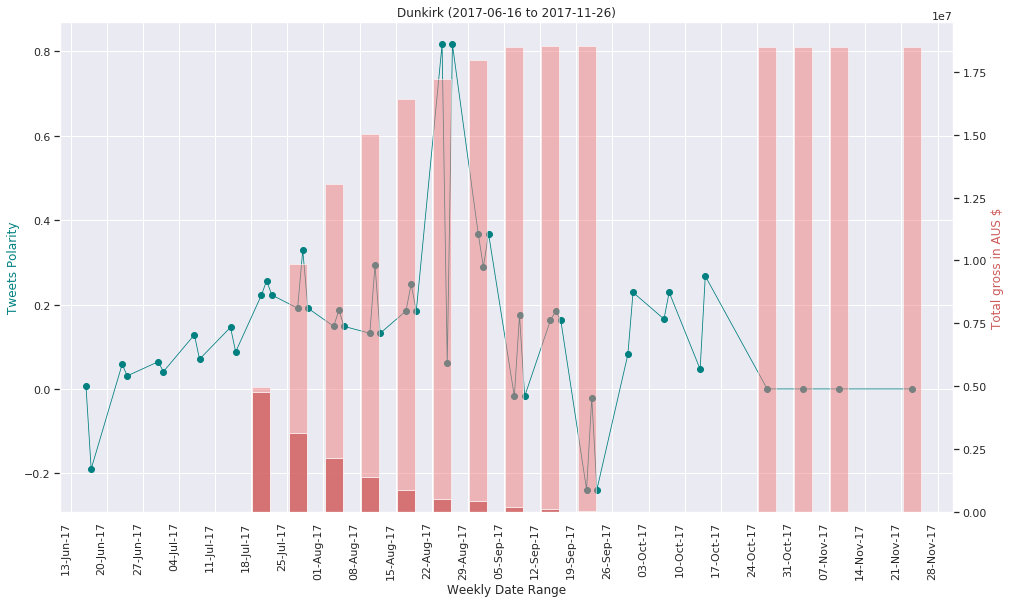

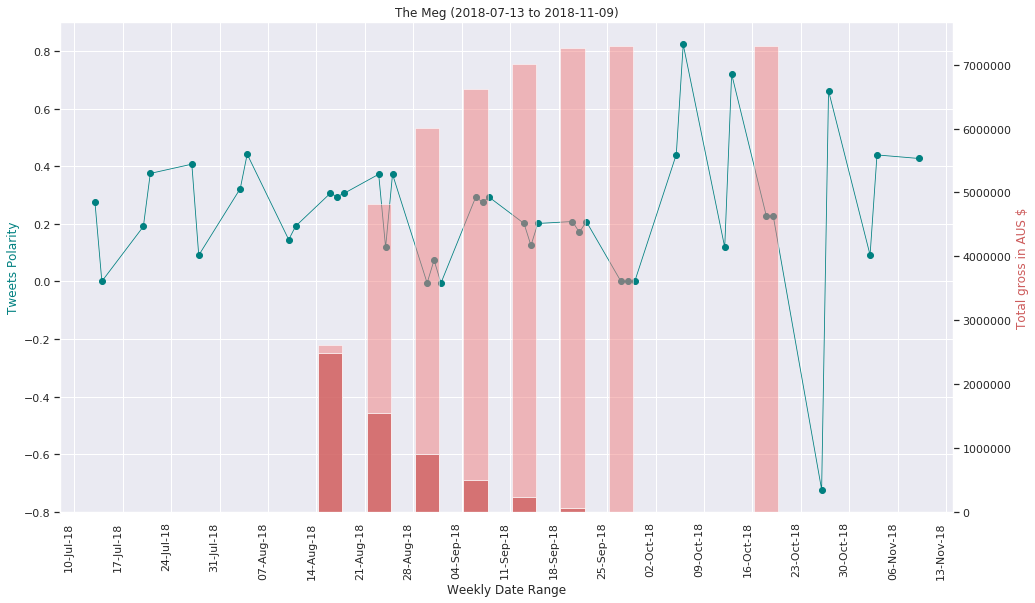

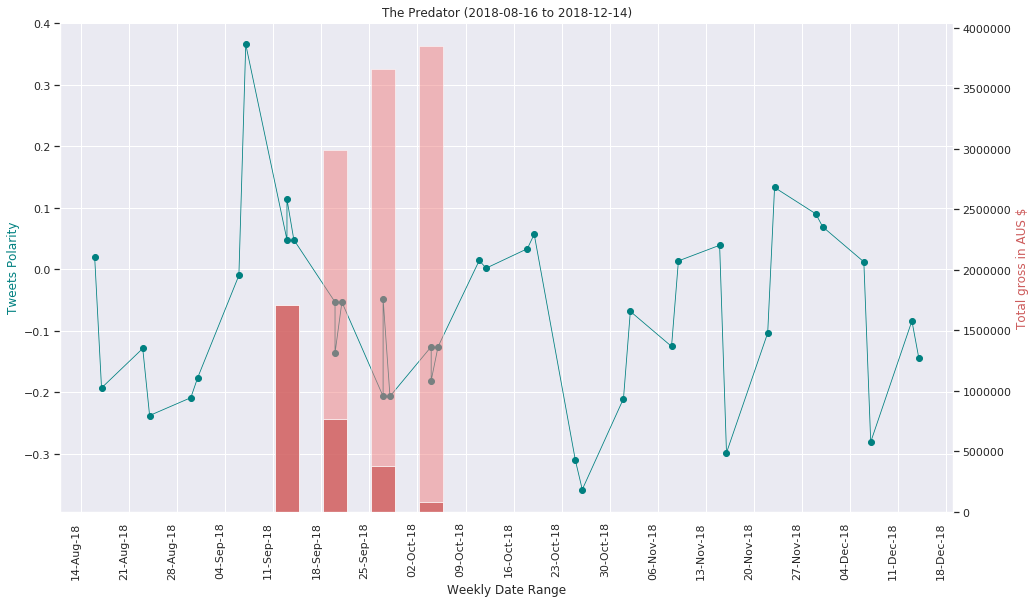

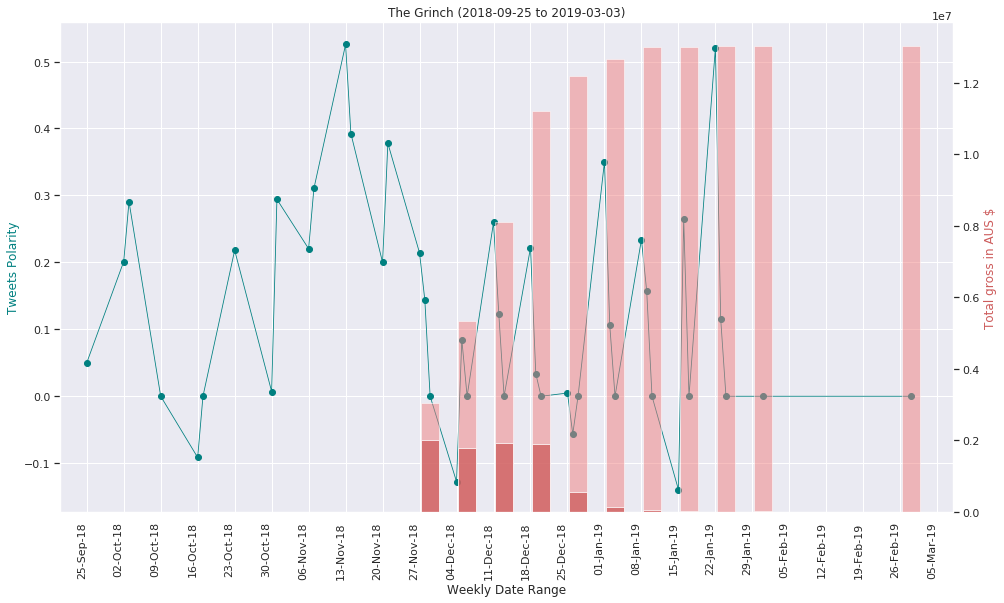

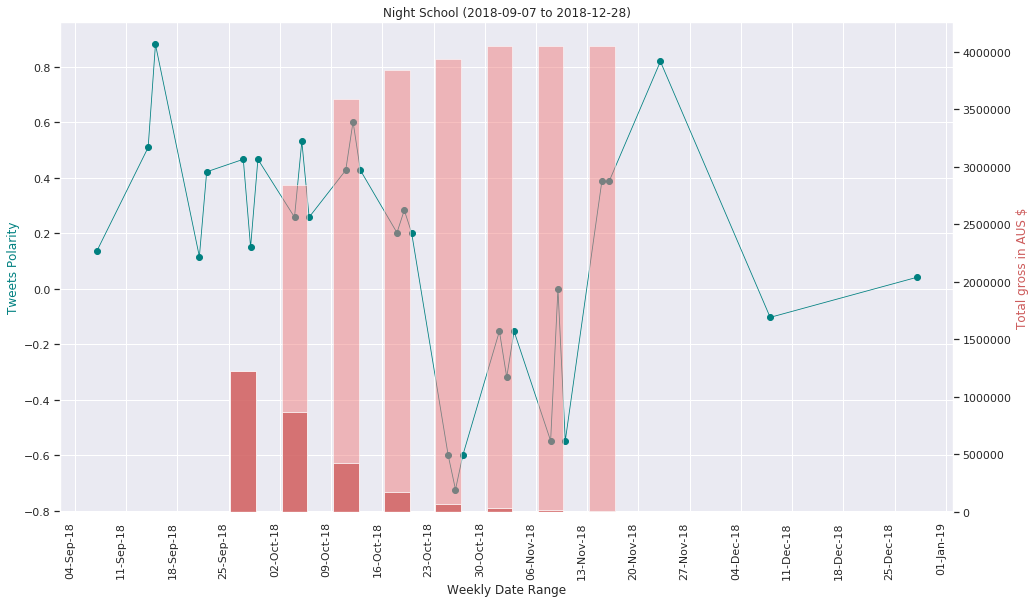

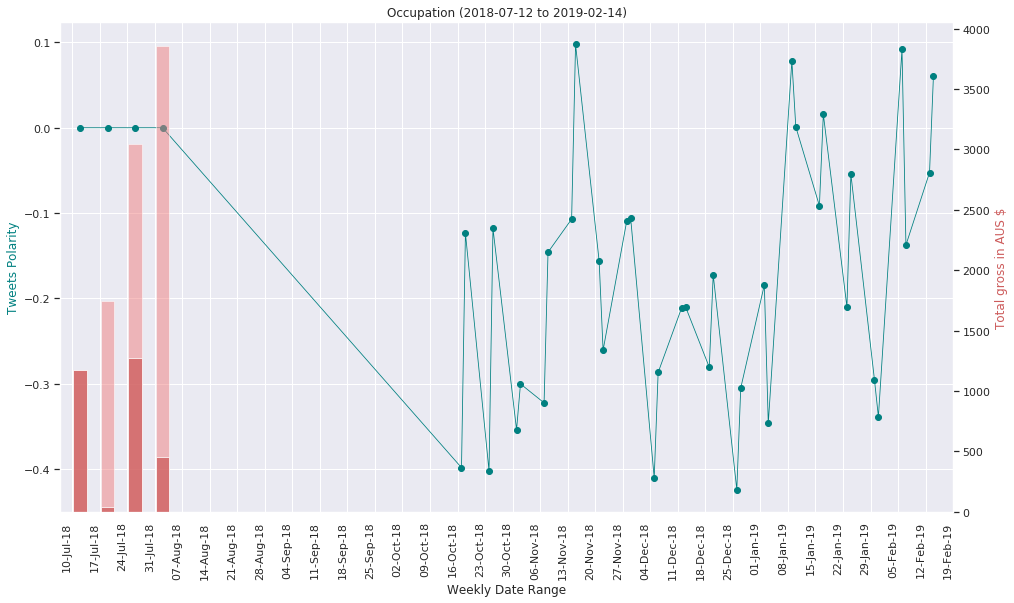

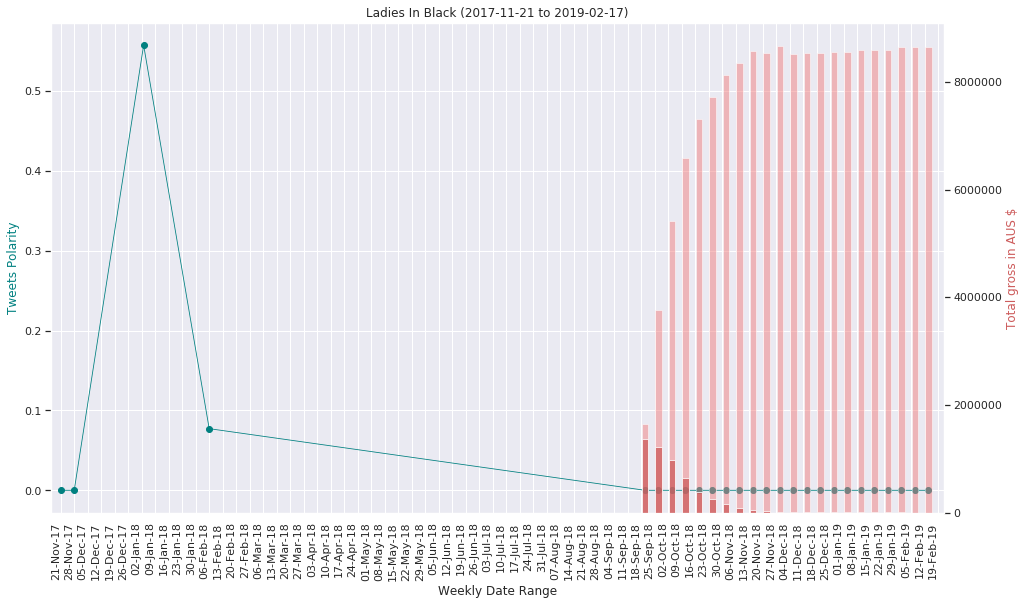

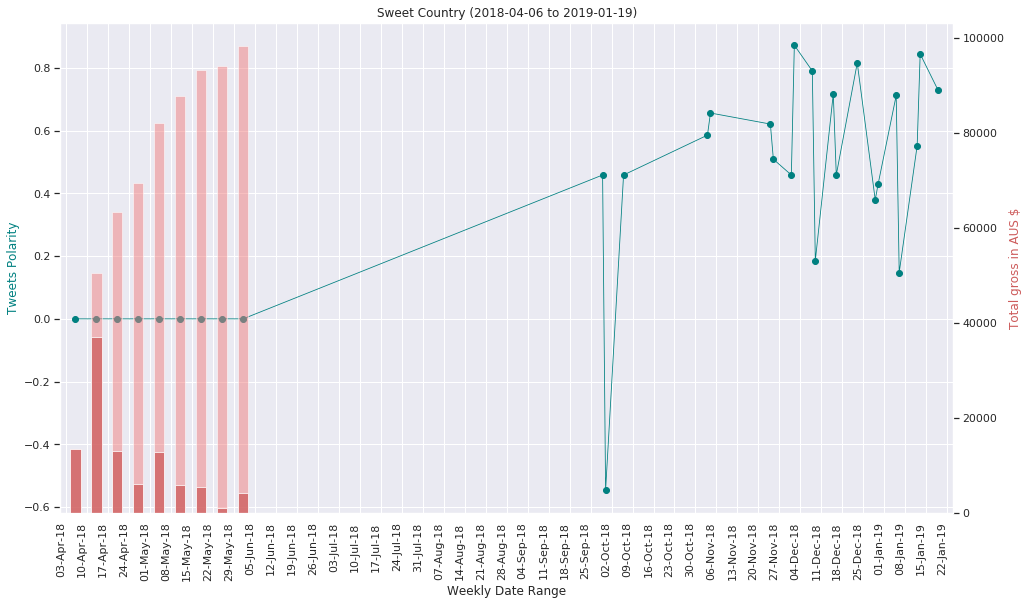

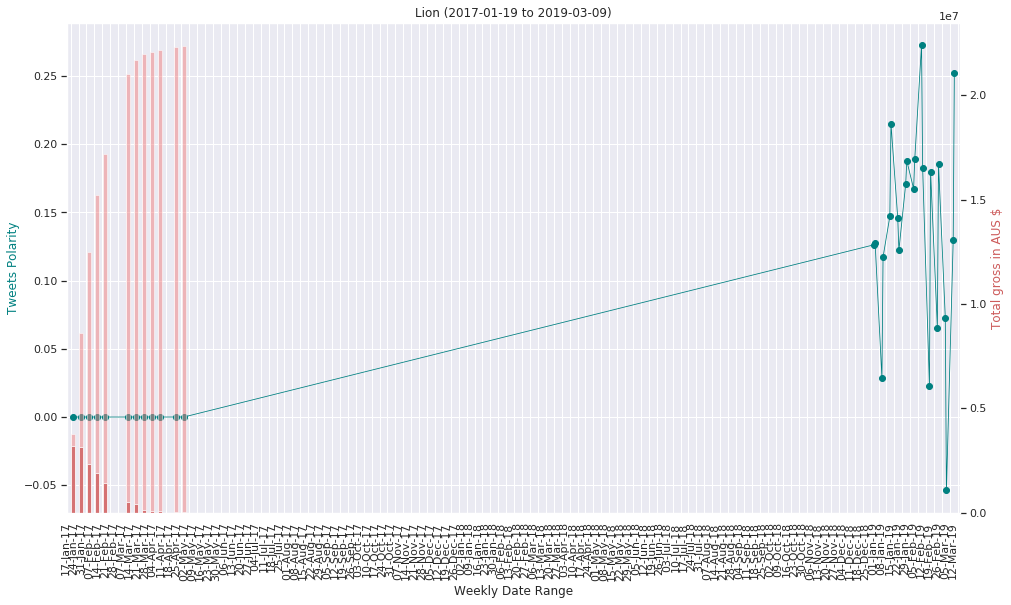

In [59]:
for group in box_vs_sentiment.groupby(['movie_id_t']):
    
    # plot for each movie individually
    # change plotting visual style.
    
    date_form = DateFormatter("%d-%b-%y")
    
    mini = group[1]
    start_date_lim = mini['begin_date'].iloc[0] - datetime.timedelta(days=5)
    end_date_lim = mini['end_date'].iloc[len(mini)-1] + datetime.timedelta(days=5)

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    ax1.set_title("{} ({} to {})".format(string.capwords(mini['Title'].iloc[0]), mini['begin_date'].iloc[0], mini['end_date'].iloc[len(mini)-1]))
    ax1.plot(mini['begin_date'], mini['tweet_sentiment'], color="teal", marker="o", linewidth=0.8)
    ax1.set_ylabel("Tweets Polarity")
    ax1.yaxis.label.set_color('teal')

    ax2 = ax1.twinx()
    ax2.bar(x=mini['begin_date'], height=mini['gross_to_date_float'], width=3.5, alpha=0.5, color="lightcoral")
    ax2.bar(x=mini['begin_date'], height=mini['weekend_gross_float'], width=3.5, alpha=0.75, color="indianred")
    ax2.set_ylabel("Total gross in AUS $")
    ax2.yaxis.label.set_color('indianred')
    ax2.grid(False)

    ax1.set_xlabel("Weekly Date Range")

    # Define the date format
    fig.autofmt_xdate(rotation=90)

    ax1.set_xlim([start_date_lim, end_date_lim])

    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

### Seasonality/Genre/Influencer effecting sales

### Any time series studies?

------------------------------------------------------------------

In [40]:
followers_freq = df_sbuzz['user_followers_count'].value_counts(sort=True, ascending=True).to_dict()

In [41]:
max(followers_freq)

10883460

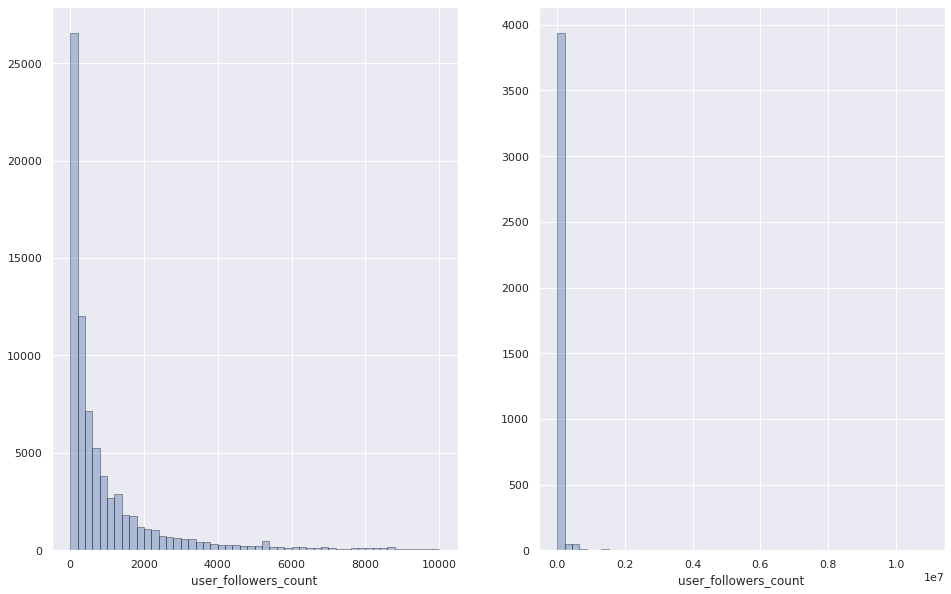

In [42]:
plt.subplot(1, 2, 1)
sns.distplot(df_sbuzz['user_followers_count'][df_sbuzz['is_influencer']==False], kde=False, hist_kws=dict(edgecolor="k"));
plt.subplot(1, 2, 2)
sns.distplot(df_sbuzz['user_followers_count'][df_sbuzz['is_influencer']==True], kde=False, hist_kws=dict(edgecolor="k"));

# there are some outliers with influencer followers count